<a href="https://colab.research.google.com/github/ram130849/Deep_Learning_Systems_Assignments/blob/main/TensorFlow/Tejas/DeepLearning_HW1_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Question 3 Dropout


# Assignment 1

Discussed with : Ramki Ramamurthy and Sushant Kotwal

References:</br>
1.https://www.tensorflow.org/tutorials/quickstart/beginner </br>
2.https://pyimagesearch.com/2021/05/06/implementing-feedforward-neural-networks-with-keras-and-tensorflow/</br>
3.https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/</br>
4.https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin</br>
5.https://www.machinelearningplus.com/plots/subplots-python-matplotlib/#:~:text=Subplots%20mean%20a%20group%20of,canvas%20that%20holds%20multiple%20plots. </br>
6.https://numpy.org/doc/stable/reference/generated/numpy.argsort.html </br>
7.https://www.tensorflow.org/guide/keras/sequential_model </br>
8  https://github.com/tensorflow/tensorflow/issues/46076 </br>
9.https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc </br>
10.https://www.tensorflow.org/guide/keras/sequential_model </br>

In [27]:
#Path: TensorFlow/Tejas/
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import keras
import keras.utils
from keras import utils as np_utils
%matplotlib inline  

Found GPU at: /device:GPU:0


In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.2


Code to check if GPU is working or not

In [3]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.9371570860000134
GPU (s):
0.041570479999990084
GPU speedup over CPU: 70x


In [4]:
# Plot ad hoc mnist instances
from tensorflow.keras.datasets import mnist

# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


we might want to flatten data later to 784 as 28,28 might give issues.

In [5]:
# Lets see the shapes of each Data sets
print("TRAIN SET:")
print("Training Set X_train shape is : {}".format(X_train.shape))
print("Training Set y_train shape is : {}".format(y_train.shape))
print("____"*25)
print("TEST SET:")
print("Test Set X_test shape is : {}".format(X_test.shape))
print("Test Set y_test shape is : {}".format(y_test.shape))

TRAIN SET:
Training Set X_train shape is : (60000, 28, 28)
Training Set y_train shape is : (60000,)
____________________________________________________________________________________________________
TEST SET:
Test Set X_test shape is : (10000, 28, 28)
Test Set y_test shape is : (10000,)


Data Preprocessing and Normalisation

In [6]:
# One way of flattening input, chose this I faced many issues with input shapes while doing it inside the model
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784) 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

One Hot Encoding

In [7]:
import keras
num_classes = 10
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

Function to define model

In [8]:
def define_model_no_drop(act_fxn,init):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1024, input_shape=(28*28,), activation=act_fxn, kernel_initializer=init),
    tf.keras.layers.Dense(units=1024, activation=act_fxn,  kernel_initializer=init),
    tf.keras.layers.Dense(units=1024, activation=act_fxn,  kernel_initializer=init),
    tf.keras.layers.Dense(units=1024, activation=act_fxn,  kernel_initializer=init),
    tf.keras.layers.Dense(units=1024, activation=act_fxn,  kernel_initializer=init),
    tf.keras.layers.Dense(units=10, activation="softmax")
  ])
  return model 

Initializations

In [9]:
normal_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
xavier_ini_normal = tf.keras.initializers.GlorotNormal()
xavier_initializer = tf.keras.initializers.GlorotUniform()
he_initializer = tf.keras.initializers.HeNormal()

In [10]:
from keras.models import Sequential
from keras.layers import  Dense, Dropout, Activation, Flatten

In [11]:
model1 = define_model_no_drop(act_fxn= 'sigmoid',init =xavier_ini_normal )


model3 = define_model_no_drop(act_fxn= 'relu',init = he_initializer)

Defining models that require dropout seperately

In [12]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28*28,)),
  tf.keras.layers.Dense(1024,activation='sigmoid',kernel_initializer=xavier_initializer),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1024,activation='sigmoid',kernel_initializer=xavier_initializer),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1024,activation='sigmoid',kernel_initializer=xavier_initializer),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1024,activation='sigmoid',kernel_initializer=xavier_initializer),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1024,activation='sigmoid',kernel_initializer=xavier_initializer),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10,activation = 'softmax')
])



In [13]:
model4 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28*28,)),
  tf.keras.layers.Dense(1024,activation='relu',kernel_initializer=he_initializer),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1024,activation='relu',kernel_initializer=he_initializer),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1024,activation='relu',kernel_initializer=he_initializer),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1024,activation='relu',kernel_initializer=he_initializer),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1024,activation='relu',kernel_initializer=xavier_initializer),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10,activation = 'softmax')
])

In [14]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(X_train, y_train, batch_size=128, epochs=500,verbose=True,validation_data=(X_test, y_test))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, batch_size=128, epochs=500,verbose=True,validation_data=(X_test, y_test))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(X_train, y_train, batch_size=128, epochs=500,verbose=True,validation_data=(X_test, y_test))

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history4 = model4.fit(X_train, y_train, batch_size=128, epochs=500,verbose=True,validation_data=(X_test, y_test))



Epoch 1/500
469/469 [==============================] - 4s 5ms/step - loss: 1.0693 - accuracy: 0.6047 - val_loss: 0.2974 - val_accuracy: 0.9111
Epoch 2/500
469/469 [==============================] - 2s 5ms/step - loss: 0.2362 - accuracy: 0.9298 - val_loss: 0.1819 - val_accuracy: 0.9471
Epoch 3/500
469/469 [==============================] - 2s 5ms/step - loss: 0.1529 - accuracy: 0.9548 - val_loss: 0.1287 - val_accuracy: 0.9625
Epoch 4/500
469/469 [==============================] - 2s 5ms/step - loss: 0.1174 - accuracy: 0.9649 - val_loss: 0.1153 - val_accuracy: 0.9653
Epoch 5/500
469/469 [==============================] - 2s 5ms/step - loss: 0.0902 - accuracy: 0.9728 - val_loss: 0.1080 - val_accuracy: 0.9701
Epoch 6/500
469/469 [==============================] - 2s 5ms/step - loss: 0.0753 - accuracy: 0.9776 - val_loss: 0.1148 - val_accuracy: 0.9677
Epoch 7/500
469/469 [==============================] - 2s 5ms/step - loss: 0.0641 - accuracy: 0.9804 - val_loss: 0.0927 - val_accuracy: 0.9737

In the above step we compiled all models and got its history out in one cell as it gave issues when I did it sepertely, asked the TA too and she did tell me seperately it might cause issues. I do not know right now why exacty, maybe cause i modularised code. But i will search this in detail later.

Lets plot the Train loss vs Test loss for both dropout and no dropout

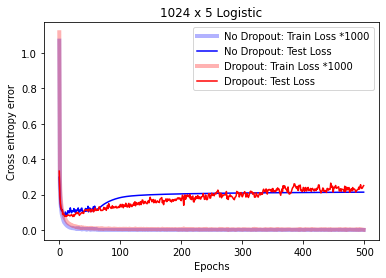

In [40]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(history1.history['loss'],color='blue',linewidth=4.0,alpha=0.3)
plt.plot(history1.history['val_loss'], color = 'blue')
plt.plot(history2.history['loss'],color='red',linewidth=4.0,alpha=0.3)
plt.plot(history2.history['val_loss'], color = 'red')

plt.legend(['No Dropout: Train Loss *1000','No Dropout: Test Loss','Dropout: Train Loss *1000','Dropout: Test Loss'])
plt.yticks(np.arange(0,1.2,0.2))
plt.xlabel('Epochs')
plt.ylabel('Cross entropy error')
plt.title('1024 x 5 Logistic')
plt.show()


For signmoid we see an increase in loss after dropout. 

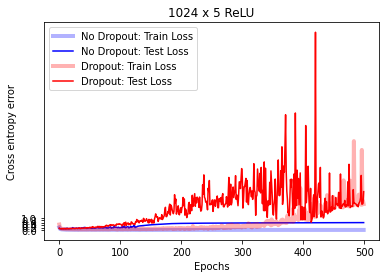

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(history3.history['loss'],color='blue',linewidth=4.0,alpha=0.3)
plt.plot(history3.history['val_loss'], color = 'blue')
plt.plot(history4.history['loss'],color='red',linewidth=4.0,alpha=0.3)
plt.plot(history4.history['val_loss'], color = 'red')

plt.legend(['No Dropout: Train Loss','No Dropout: Test Loss','Dropout: Train Loss','Dropout: Test Loss'])
plt.yticks(np.arange(0,1.2,0.2))
plt.xlabel('Epochs')
plt.ylabel('Cross entropy error')
plt.title('1024 x 5 ReLU')
plt.show()

Model Saving

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [38]:

 
# assign location
path=F"/content/gdrive/My Drive/Models/model1"
 
# save
model1.save_weights(path,save_format='tf')
# assign location
path=F"/content/gdrive/My Drive/Models/model2"
model2.save_weights(path,save_format='tf')
# assign location
path=F"/content/gdrive/My Drive/Models/model3"
model3.save_weights(path,save_format='tf')
# assign location
path=F"/content/gdrive/My Drive/Models/model4"
model4.save_weights(path,save_format='tf')

In [39]:
# assign location
path=F"/content/gdrive/My Drive/Models/DLHW1Q3model1"
 
# save
model1.save(path,save_format='tf')
# assign location
path=F"/content/gdrive/My Drive/Models/DLHW1Q3model2"
model2.save(path,save_format='tf')
# assign location
path=F"/content/gdrive/My Drive/Models/DLHW1Q3model3"
model3.save(path,save_format='tf')
# assign location
path=F"/content/gdrive/My Drive/Models/DLHW1Q3model4"
model4.save(path,save_format='tf')

In [17]:
model1.save("name.h5")

In [18]:
model2.save("name.h5")

In [19]:
model3.save("name.h5")

In [20]:
model4.save("name.h5")